## Exercise 5.4 SVM (4 points)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles

### Generating the data

In [2]:
X, y = make_circles(n_samples=500, noise=0.05, random_state=42)
df = pd.DataFrame(dict(x1=X[:, 0], x2=X[:, 1], y=y))

#map classes to -1 and 1 for simplification
df["y"] = df["y"].apply(lambda x: x if x else -1)

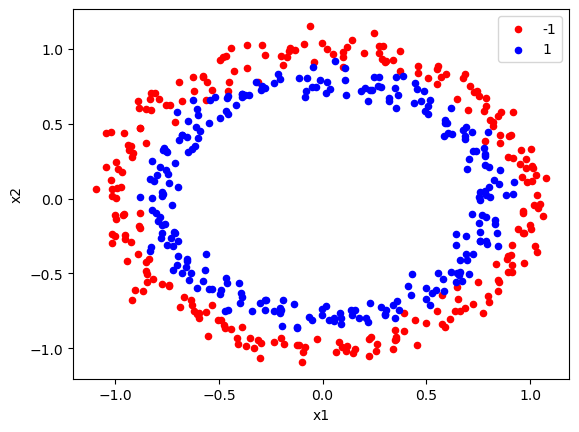

In [3]:
colors = {-1: "red", 1: "blue"}
fig, ax = plt.subplots()
grouped = df.groupby("y")
for key, group in grouped:
    group.plot(ax=ax, kind="scatter", x="x1", y="x2", label=key, color=colors[key])
plt.show()

In [73]:
from sklearn.model_selection import train_test_split

X = df[["x1", "x2"]]
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42
)

### SVM (4 points)

Support Vector Machines (SVMs) are a powerful and versatile class of supervised machine learning algorithms used for classification and regression tasks. At their core, SVMs aim to find a hyperplane that best separates different classes of data. The beauty of SVMs lies in their ability to handle both linear and non-linear data using kernel functions.

In a two-dimensional space, an SVM finds a line (and in higher dimensions, a hyperplane) that best separates the classes. This line is determined by the support vectors, which are the data points nearest to the hyperplane.
The equation of the hyperplane can be represented as:
The equation of the hyperplane can be represented as:
$$ w \cdot x + b = 0 $$
where \( w \) is the weight vector and \( b \) is the bias.


The regularized hinge loss, which is used for training Support Vector Machines with L2 regularization, is given by:
   $$ L(w,b) = \frac{\lambda}{2} ||w||^2 + \sum_{i} \max(0, 1 - y_i(w \cdot x_i + b)) $$

where:
- \( \lambda \) is the regularization parameter.
- \( w \) is the weight vector.
- \( b \) is the bias term.
- \( x_i \) is the feature vector of the \( i^{th} \) data point.
- \( y_i \) is the actual label of the \( i^{th} \) data point, with \( y_i \in \{ -1, 1 \} \).


For non-linearly separable data, SVMs use the kernel trick. A kernel function transforms the data into a higher-dimensional space where it becomes linearly separable. Common kernels include the linear, polynomial, and radial basis function (RBF) kernels.

### The Polynomial Kernel
The polynomial kernel function, commonly used with SVMs, is defined as:

$$ K(x_1, x_2) = (x_1^T x_2 + c)^d $$

where:
- \( x_1 \) and \( x_2 \) are two input vectors.
- \( x_1^T x_2 \) represents the dot product of \( x_1 \) and \( x_2 \).
- \( c \) is a constant term that allows for tuning of the kernel's behavior.
- \( d \) is the degree of the polynomial.

where **c** is a constant and **x1** and **x2**  are vectors in the original space.

The parameter **c** can be used to control the trade-off between the fit of the training data and the size of the margin. A large **c** value will give a low training error but may result in overfitting. A small **c** value will give a high training error but may result in underfitting. The degree **d** of the polynomial can be used to control the complexity of the model. A high degree d will result in a more complex model that may overfit the data, while a low degree **d** will result in a simpler model that may underfit the data.

When a dataset is given containing features x1 and x2, the equation can be transformed as:
$$
\begin{bmatrix}
x_1 \\
x_2 
\end{bmatrix}
\cdot
\begin{bmatrix}
x_1 & x_2
\end{bmatrix}
=
\begin{bmatrix}
x_1^2 & x_1 x_2 \\
x_1 x_2 & x_2^2
\end{bmatrix}
$$

The important terms we need to note are **x1**, **x2**, **x1^2**, **x2^2** , and **x1 * x2**. When finding these new terms, the non-linear dataset is converted to another dimension that has features **x1^2**, **x2^2** , and **x1 * x2**.


**Note**: When employing the polynomial kernel, it is crucial to ensure that you apply this kernel transformation to both the training data during the 'fit' function and the test data during the 'predict' function. 

### Implementing SVM 

In [111]:
import numpy as np

class SVM:
    def __init__(self, 
                C=1.0, 
                learning_rate=0.001, 
                lambda_param=1e-2, 
                kernel=None):
        # C = error term
        self.C = C
        self.lambda_param = lambda_param
        self.lr = learning_rate
        self.kernel = kernel

    def polynomial_transform(self, X, Y=None):
        # implement the polynomial transformation based on the equation given above
        d = 1
        if self.kernel == 'poly': # Use polynomial transform of order 2
            d = 2

        # Creates an upper triangular mask. For example, for len(x) = 2
        # [[1, 1]
        #  [0, 1]]
        # This will be used to get the polynomial features out of x^T * x
        # Since x^T * x is symmetric and we don't want to repeat values,
        # we only take the upper triangular ones (we could also take the
        # lower triangular ones)
        mask = np.tri(X.shape[0], k=0, dtype=int).T
        
        if Y:
            poly_features = np.dot(X, Y.T)
        else:
            poly_features = np.dot(X, X.T)

        features = poly_features[mask == 1].ravel() # 1-D vector
        return np.power(features + self.C, d) # Element-wise power to d

    def update(self, dw, db):
        #update w and b based on the gradients
        self.w -= self.lr * dw
        self.b -= self.lr * db

    def calculate_gradients(self, x, y, loss):
        # calculate gradients
        # If the second term of the max function is <= 0, then the whole term
        # will be 0, therefore it is not taken into account for the gradient
        if 1 - np.dot(y, self.forward(x)) < 0: 
            dw = self.lambda_param * np.linalg.norm(self.w, 2)
            db = 0
        else: # if it is greater than 0, the term should be taken into account 
            dw = self.lambda_param * np.linalg.norm(self.w, 2) - x * y
            db = -y
        return dw, db

    def forward(self, X):
        return np.dot(self.w, X.T) + self.b

    def hinge_loss(self, output, y):
        reg = 0.5 * np.linalg.norm(self.w, 2) ** 2
        return reg + np.maximum(0, 1 - y * output)

    def init_weights(self, X):
        # Initialize the wights and biases to 0
        # If X has 2 features, then the kernel trick would give us 3 values,
        # so we need 3 weights, one for each x1^2, x2^2 and x1 * x2
        n_features = X.shape[1]
        n = (n_features * (n_features + 1)) // 2
        self.w = np.zeros(n)
        self.b = 0

    def fit(self, X, Y, epochs=1000):
        #Implement gradient descent
        if type(X) != np.ndarray:
            X = X.to_numpy()
        
        if type(Y) != np.ndarray:
            Y = Y.to_numpy()

        self.init_weights(X)
        
        for _ in range(epochs):
            for i, x in enumerate(X):
                x = x.reshape(-1, 1) # Makes a (2,) into a (2,1) shape
                x_p = self.polynomial_transform(x)
                output = self.forward(x_p)
                loss = self.hinge_loss(output, Y[i])
                dw, db = self.calculate_gradients(x_p, Y[i], loss)
                self.update(dw, db)

    def predict(self, X):
        X_p = self.polynomial_transform(X)
        output = self.forward(X_p)
        return np.sign(output)

### SVM class with a linear kernel

Create an SVM with linear kernel and calulate the accuracy score

In [112]:
from sklearn.metrics import accuracy_score

linear_svm = SVM()
linear_svm.fit(X_train, y_train)
y_train_predicted = linear_svm.predict(X_train)
y_test_predicted = linear_svm.predict(y_train)

print(f"Training Accuracy = {accuracy_score(y_train, y_train_predicted)}")
print(f"Test Accuracy = {accuracy_score(y_test, y_test_predicted)}")

1.0
1.005521861084651
0.9993567155612388
0.9937164044140685
1.0121260179998057
0.9920138335500854
0.9854882507067346
1.0182186377427969
1.0121812523120808
0.9926550722236912
1.0124900015021152
1.0088347621399907
1.0027641363220623
0.9975210920785595
1.0087612888234865
0.9969605461436388
1.006252143235125
0.9993769630453462
1.0036670645413281
0.9995960311304781
0.995529236544028
1.008656948704175
0.9916574560436937
1.00925020711342
1.0066836583305574
0.9967426017061618
1.0067570164426516
0.9999302236541547
1.0034247386972763
1.0042123338075128
0.989689251447116
1.0126809821780844
0.9957474083215943
0.9870098715324119
1.0176170370747173
0.9869352725129824
1.0167082011330117
1.0139302927632659
0.9879920811970214
1.0149218578480261
0.9889360752939185
1.0130036122610648
1.0109547937245031
1.0036759147779324
0.997886811456684
0.9993734562784414
1.0126022401293764
1.0062983303673971
0.9997017748926653
1.0065669292169088
0.9975216711839605
1.0093313471918153
1.0016018096483612
1.00443333943287

KeyboardInterrupt: 

### SVM class with a polynomial kernel

Create an SVM with polynomial kernel and calulate the accuracy score

#### Plotting the transformed input 

In [ ]:
import plotly.express as px

def plot_transformed(df):
    df["x1^2"] = df["x1"] ** 2
    df["x2^2"] = df["x2"] ** 2
    df["x1*x2"] = df["x1"] * df["x2"]

    fig = px.scatter_3d(df, x="x1^2", y="x2^2", z="x1*x2", color="y")
    fig.show()

plot_transformed(df)

#### Using SVM on real dataset (1 point)

Utilize the Support Vector Machine (SVM) with a polynomial kernel to tackle the task of classifying Flower Species. Given that this problem involves multiple classes and the SVMyou implemented is a binary classifier, employ the [one-vs-all](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/one-vs-all#:~:text=all%20provides%20a%20way%20to,classifier%20for%20each%20possible%20outcome.) classification strategy. This approach will enable you to train a separate classifier for each possible outcome, effectively addressing the multi-class nature of the problem.

In [4]:
df = pd.read_csv("./IRIS.csv")
df.sample(3)

,sepal_length,sepal_width,petal_length,petal_width,species
112,6.8,3.0,5.5,2.1,Iris-virginica
88,5.6,3.0,4.1,1.3,Iris-versicolor
43,5.0,3.5,1.6,0.6,Iris-setosa
